In [ ]:
!pip install py2neo

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [3]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark

In [7]:
from py2neo import Graph

In [8]:
import pandas as pd
from numpy.random import randint

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [10]:
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [11]:
from cycler import cycler
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [12]:
graph = Graph("bolt://thisismatrix.centralindia.cloudapp.azure.com:7687", auth=("neo4j", "neo4j"))

In [13]:
# ////////////////////////////////////////////////////////////////////////////////

In [14]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

In [15]:
query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""
by_year = graph.run(query).to_data_frame()

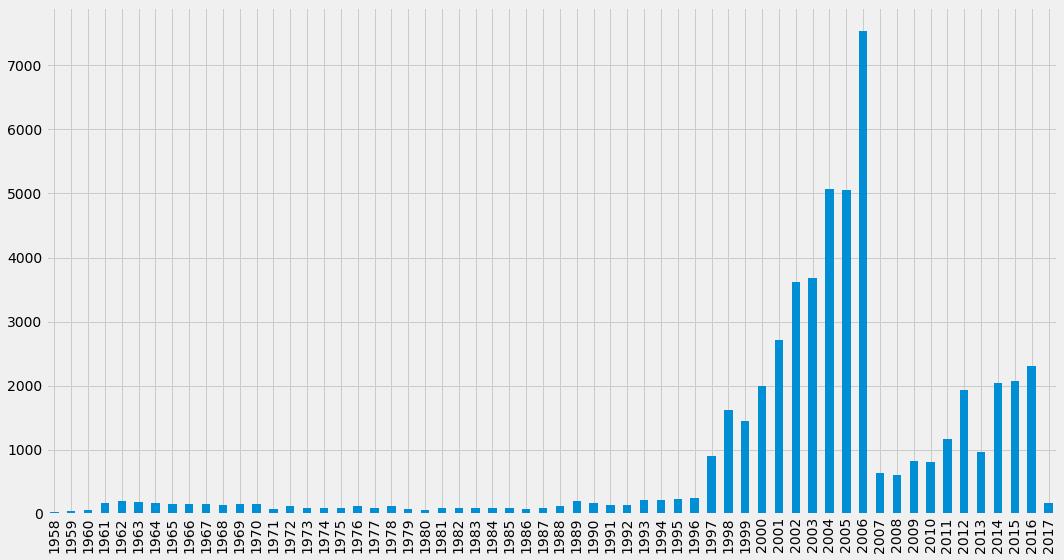

In [16]:
%matplotlib inline
plt.style.use('fivethirtyeight')
ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

In [17]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [18]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

In [19]:
train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

In [20]:
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [21]:
training_df = down_sample(training_df)

In [22]:
training_data = spark.createDataFrame(training_df)

In [23]:
training_data.show(n=5)

+-----+------+-----+
|node1| node2|label|
+-----+------+-----+
|74155| 96608|    0|
|44620| 20193|    0|
|26438|121212|    0|
|69140| 22039|    1|
|47645| 10175|    0|
+-----+------+-----+
only showing top 5 rows



In [24]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|81096|
|    1|81096|
+-----+-----+



In [25]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

In [26]:
test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

In [27]:
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

In [28]:
test_df = down_sample(test_df)

In [29]:
test_data = spark.createDataFrame(test_df)

In [30]:
test_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|74128|
|    1|74128|
+-----+-----+



In [31]:
def create_pipeline(fields):
  assembler = VectorAssembler(inputCols=fields, outputCol="features")
  rf = RandomForestClassifier(labelCol="label", featuresCol="features",
  numTrees=30, maxDepth=10)
  return Pipeline(stages=[assembler, rf])

In [32]:
def apply_graphy_training_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [33]:
def apply_graphy_test_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [35]:
training_data = apply_graphy_training_features(training_data)

In [37]:
test_data = apply_graphy_test_features(test_data)

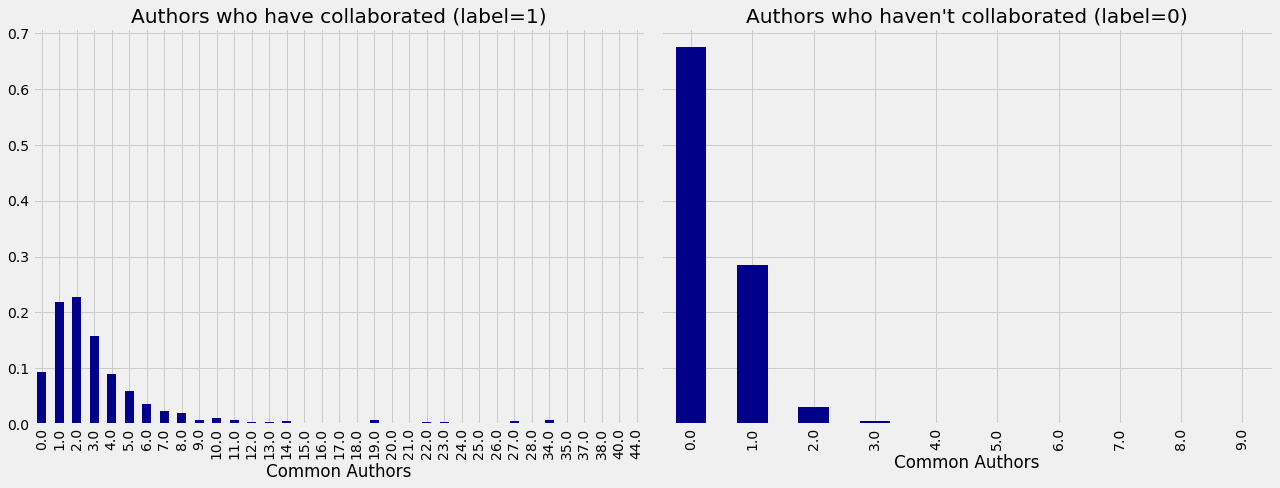

In [38]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  common_authors = filtered.toPandas()["commonAuthors"]
  histogram = common_authors.value_counts().sort_index()
  histogram /= float(histogram.sum())
  histogram.plot(kind="bar", x='Common Authors', color="darkblue",
  ax=axs[index], title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Common Authors")
  
plt.tight_layout()
plt.show()

In [39]:
def train_model(fields, training_data):
  pipeline = create_pipeline(fields)
  model = pipeline.fit(training_data)
  return model

In [40]:
basic_model = train_model(["commonAuthors"], training_data)

In [41]:
eval_df = spark.createDataFrame(
[(0,), (1,), (2,), (10,), (100,)],
['commonAuthors'])
(basic_model.transform(eval_df)
.select("commonAuthors", "probability", "prediction")
.show(truncate=False))

+-------------+----------------------------------------+----------+
|commonAuthors|probability                             |prediction|
+-------------+----------------------------------------+----------+
|0            |[0.7545836449973726,0.24541635500262735]|0.0       |
|1            |[0.7545836449973726,0.24541635500262735]|0.0       |
|2            |[0.05346524875647528,0.9465347512435247]|1.0       |
|10           |[0.05346524875647528,0.9465347512435247]|1.0       |
|100          |[0.05346524875647528,0.9465347512435247]|1.0       |
+-------------+----------------------------------------+----------+



In [42]:
def evaluate_model(model, test_data):
  # Execute the model against the test set
  predictions = model.transform(test_data)
  # Compute true positive, false positive, false negative counts
  tp = predictions[(predictions.label == 1) &
  (predictions.prediction == 1)].count()
  fp = predictions[(predictions.label == 0) &
  (predictions.prediction == 1)].count()
  fn = predictions[(predictions.label == 1) &
  (predictions.prediction == 0)].count()
  # Compute recall and precision manually
  recall = float(tp) / (tp + fn)
  precision = float(tp) / (tp + fp)
  # Compute accuracy using Spark MLLib's binary classification evaluator
  accuracy = BinaryClassificationEvaluator().evaluate(predictions)
  # Compute false positive rate and true positive rate using sklearn functions
  labels = [row["label"] for row in predictions.select("label").collect()]
  preds = [row["probability"][1] for row in predictions.select
  ("probability").collect()]
  fpr, tpr, threshold = roc_curve(labels, preds)
  roc_auc = auc(fpr, tpr)
  return { "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "accuracy": accuracy,
  "recall": recall, "precision": precision }

In [43]:
def display_results(results):
  results = {k: v for k, v in results.items() if k not in
  ["fpr", "tpr", "roc_auc"]}
  return pd.DataFrame({"Measure": list(results.keys()),
  "Score": list(results.values())})

In [44]:
basic_results = evaluate_model(basic_model, test_data)

In [45]:
display_results(basic_results)

,Measure,Score
0,accuracy,0.864478
1,recall,0.753278
2,precision,0.968721


In [46]:
def create_roc_plot():
  plt.style.use('classic')
  fig = plt.figure(figsize=(13, 8))
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.rc('axes', prop_cycle=(cycler('color',['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
  plt.plot([0, 1], [0, 1], linestyle='--', label='Random score(AUC = 0.50)')
  return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
  plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")

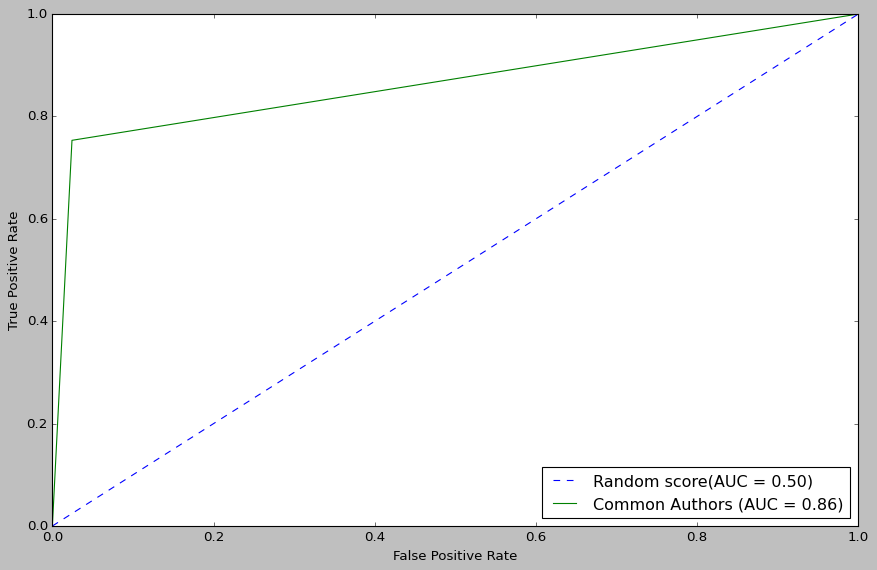

In [47]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

In [48]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours").show())

+-------+------------------+------------------+------------------+
|summary|     commonAuthors|    prefAttachment|   totalNeighbours|
+-------+------------------+------------------+------------------+
|  count|             81096|             81096|             81096|
|   mean|3.5959233501035808| 69.93537289138798|10.082408503502021|
| stddev| 4.715942231635515|171.47092255919475| 8.441099709206844|
|    min|               0.0|               1.0|               2.0|
|    max|              44.0|            3150.0|              90.0|
+-------+------------------+------------------+------------------+

+-------+------------------+-----------------+------------------+
|summary|     commonAuthors|   prefAttachment|   totalNeighbours|
+-------+------------------+-----------------+------------------+
|  count|             81096|            81096|             81096|
|   mean|0.3754932425766992|48.45124297129328| 12.97670661931538|
| stddev|0.6133204495705995|96.52065733430454|10.097803369294533|


In [49]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours"]
graphy_model = train_model(fields, training_data)

In [50]:
graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)

,Measure,Score
0,accuracy,0.977607
1,recall,0.922769
2,precision,0.943750


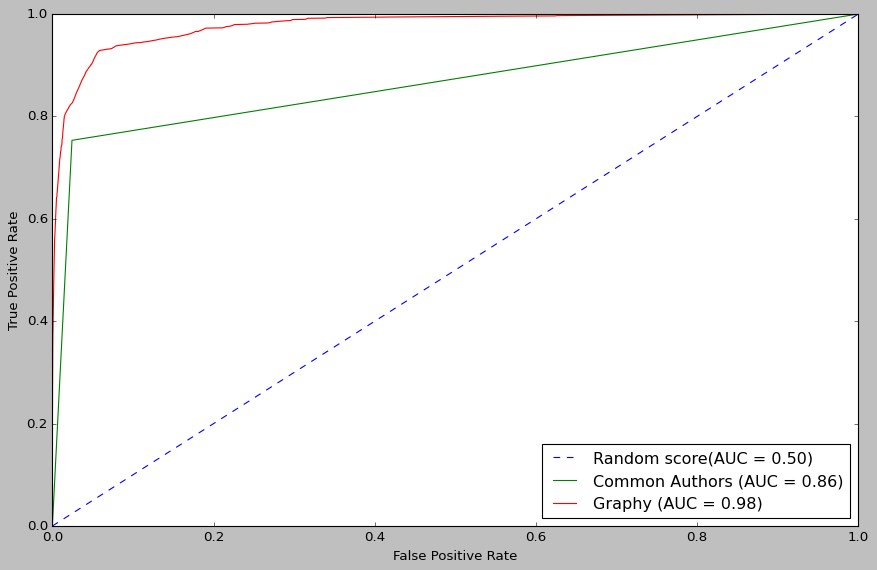

In [51]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"],basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

In [52]:
def plot_feature_importance(fields, feature_importances):
  df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
  df = df.sort_values("Importance", ascending=False)
  ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
  ax.xaxis.set_label_text("")
  plt.tight_layout()
  plt.show()

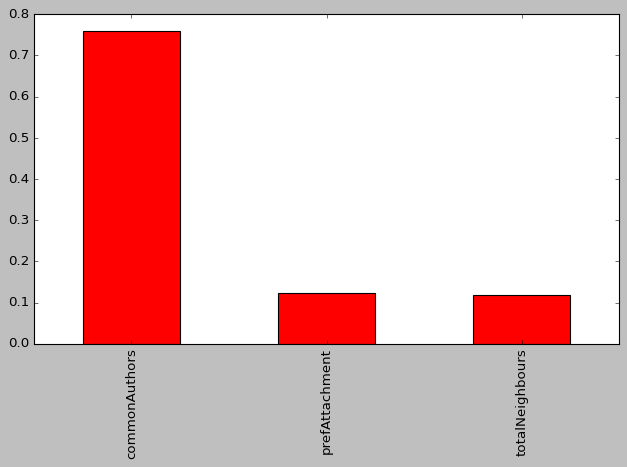

In [53]:
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [ ]:
from spark_tree_plotting import export_graphviz

In [61]:
# The Python spark plotting lib

In [54]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
  AS minTriangles,
  apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
  AS maxTriangles,
  apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
  AS minCoefficient,
  apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
  AS maxCoefficient
  """
  params = {
  "pairs": [{"node1": row["node1"], "node2": row["node2"]}
  for row in data.collect()],
  "trianglesProp": triangles_prop,
  "coefficientProp": coefficient_prop
  }
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [56]:
training_data = apply_triangles_features(training_data,"trianglesTrain", "coefficientTrain")

In [58]:
test_data = apply_triangles_features(test_data,"trianglesTest", "coefficientTest")

In [59]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "minTriangles", "maxTriangles","minCoefficient", "maxCoefficient").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "minTriangles", "maxTriangles", "minCoefficient","maxCoefficient").show())

+-------+-----------------+-----------------+------------------+------------------+
|summary|     minTriangles|     maxTriangles|    minCoefficient|    maxCoefficient|
+-------+-----------------+-----------------+------------------+------------------+
|  count|            81096|            81096|             81096|             81096|
|   mean| 18.6603408306205|26.05089030285094|0.5428444183795761|0.8103399146429806|
| stddev|64.10048787360263|72.10424208951943|0.3733410264633554|0.3161520553390558|
|    min|                0|                0|               0.0|               0.0|
|    max|              615|              780|               1.0|               1.0|
+-------+-----------------+-----------------+------------------+------------------+

+-------+-----------------+------------------+-------------------+------------------+
|summary|     minTriangles|      maxTriangles|     minCoefficient|    maxCoefficient|
+-------+-----------------+------------------+-------------------+-----

In [60]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient"]
triangle_model = train_model(fields, training_data)

In [61]:
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.990048
1,recall,0.946849
2,precision,0.954251


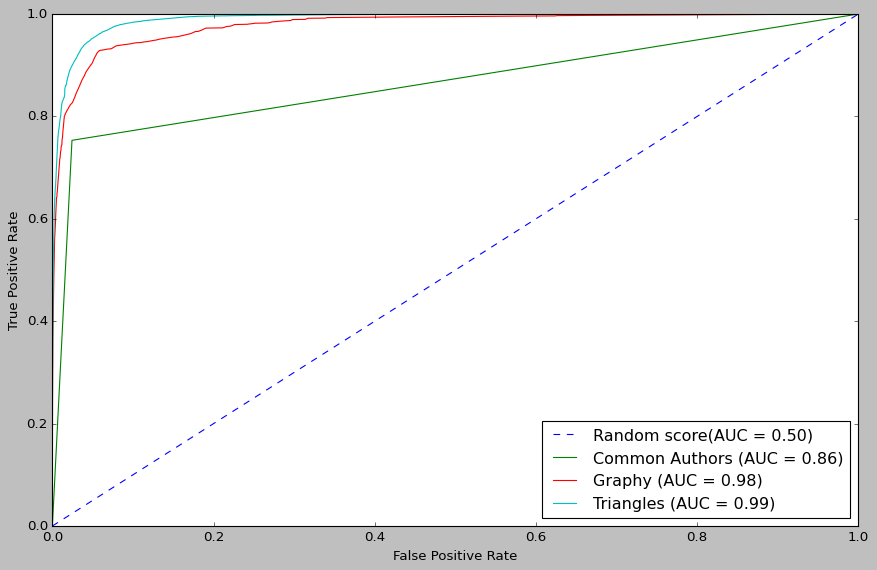

In [62]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

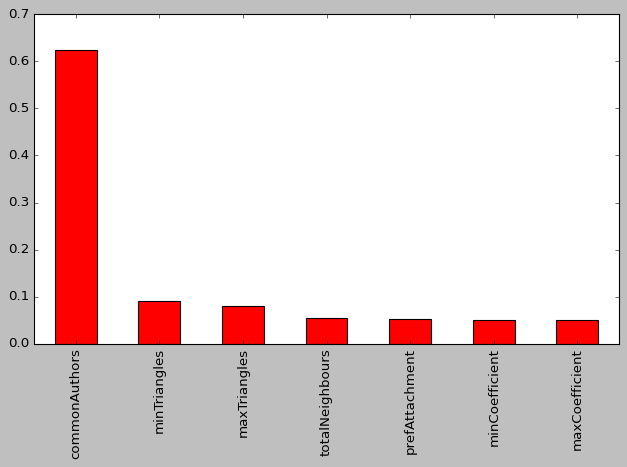

In [63]:
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

In [66]:
# Community

In [64]:
def apply_community_features(data, partition_prop, louvain_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
  1 ELSE 0 END AS samePartition,
  CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
  1 ELSE 0 END AS sameLouvain
  """
  params = {"pairs": [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()],"partitionProp": partition_prop,"louvainProp": louvain_prop}
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [66]:
training_data = apply_community_features(training_data,"partitionTrain", "louvainTrain")

In [68]:
test_data = apply_community_features(test_data, "partitionTest", "louvainTest")

In [69]:
import pyspark.sql.functions as F

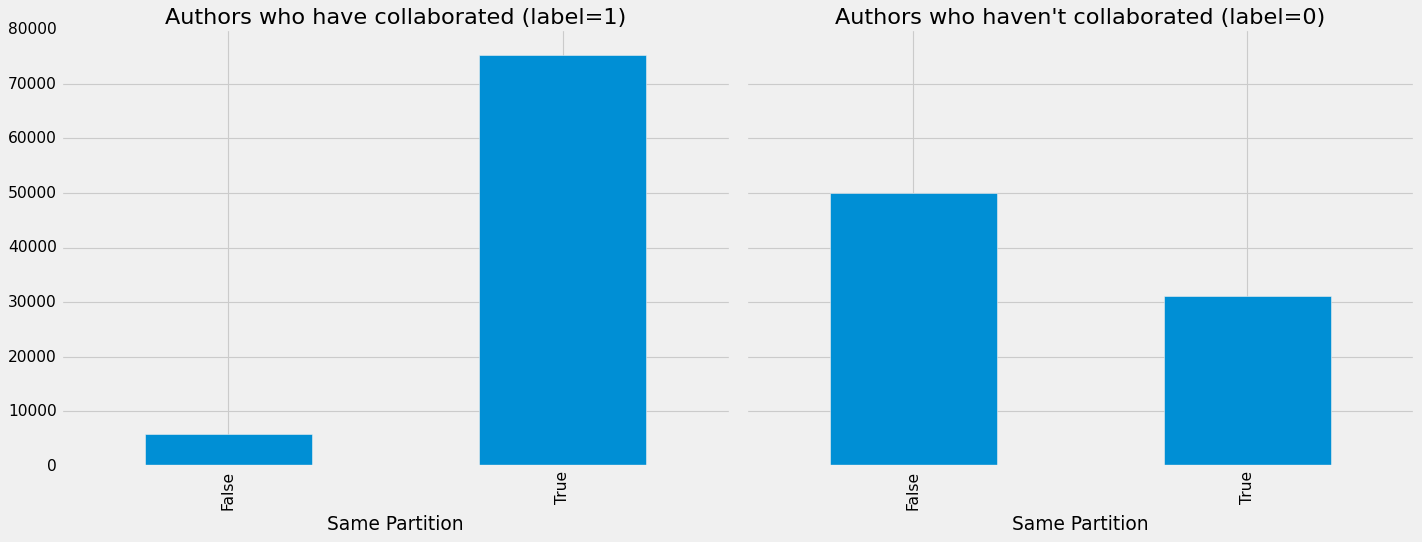

In [70]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('samePartition',
  F.when(F.col("samePartition") == 0, "False")
  .otherwise("True"))
  .groupby("samePartition")
  .agg(F.count("label").alias("count"))
  .select("samePartition", "count")
  .toPandas())
  values.set_index("samePartition", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

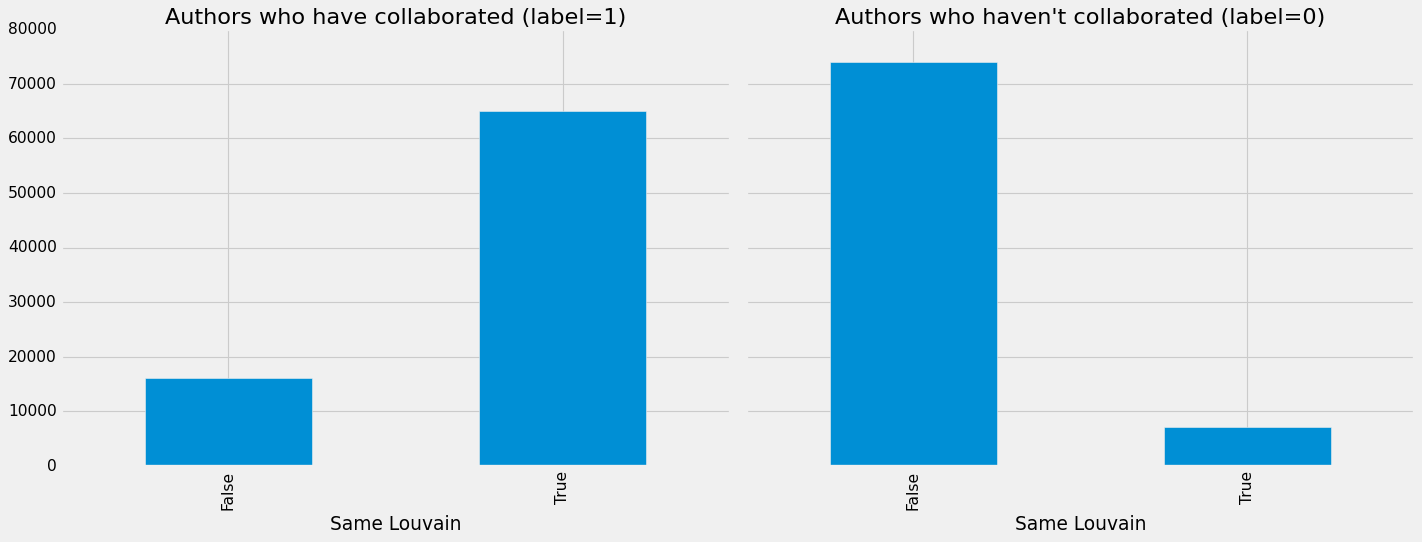

In [71]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('sameLouvain',
  F.when(F.col("sameLouvain") == 0, "False")
  .otherwise("True"))
  .groupby("sameLouvain")
  .agg(F.count("label").alias("count"))
  .select("sameLouvain", "count")
  .toPandas())
  values.set_index("sameLouvain", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Louvain")
  
plt.tight_layout()
plt.show()

In [72]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient","samePartition", "sameLouvain"]
community_model = train_model(fields, training_data)

In [73]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.994759
1,recall,0.965506
2,precision,0.973490


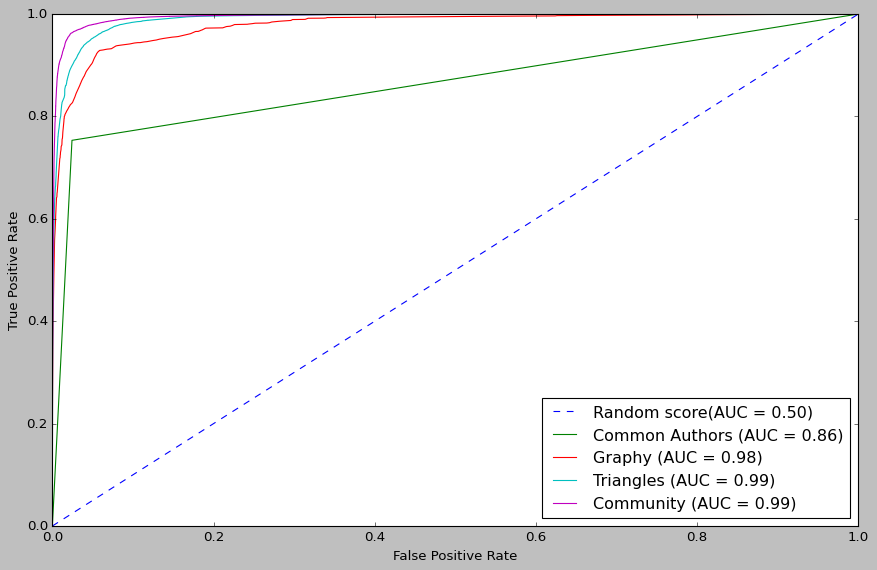

In [74]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
add_curve(plt, "Community",community_results["fpr"], community_results["tpr"],community_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

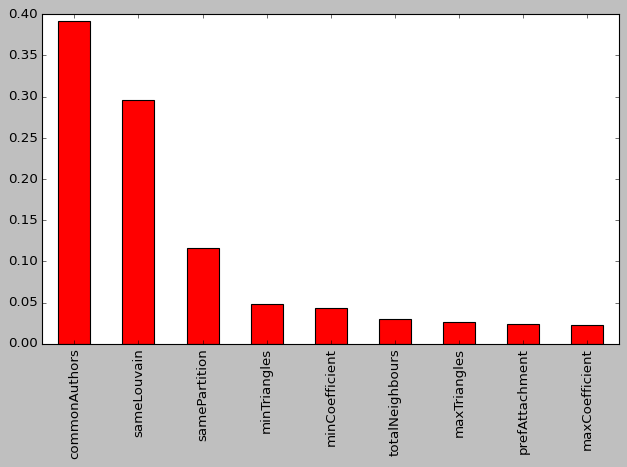

In [75]:
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)